# **Data Cleaning**

## **0. Import Libraries**

In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math

---
## **1. Import Data**

In [475]:
orders = pd.read_csv('../data/raw/train/df_Orders.csv')
order_items = pd.read_csv('../data/raw/train/df_OrderItems.csv')
customers = pd.read_csv('../data/raw/train/df_Customers.csv')
payments = pd.read_csv('../data/raw/train/df_Payments.csv')
products = pd.read_csv('../data/raw/train/df_Products.csv')

## **2. Data Type Conversion**

### Orders Data (df_Orders.csv)

**🧼 Data Cleaning Summary — Orders File**
- Changed data types for all timestamp columns.
- Removed 2016 data (insignificant and noisy).
- Removed rows where order_status = 'canceled' but had non-null delivery timestamp.
- Dropped delivered rows with missing delivery timestamp.
- Calculated `delivery_time_gap_hrs` and removed extreme outliers using KDE and CDF plots.
- Added new features: `delivery_time_gap`, `delivery_time_gap_hrs`, `purchase_to_approval_hours`, `approval_to_delivery_hours`.

In [476]:
orders['order_id'] = orders['order_id'].astype('string')
orders['customer_id'] = orders['customer_id'].astype('string')
orders['order_status'] = orders['order_status'].astype('category')

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_timestamp'] = pd.to_datetime(orders['order_delivered_timestamp'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [477]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       89316 non-null  string        
 1   customer_id                    89316 non-null  string        
 2   order_status                   89316 non-null  category      
 3   order_purchase_timestamp       89316 non-null  datetime64[ns]
 4   order_approved_at              89307 non-null  datetime64[ns]
 5   order_delivered_timestamp      87427 non-null  datetime64[ns]
 6   order_estimated_delivery_date  89316 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](4), string(2)
memory usage: 4.2 MB


---
#### Removing the insignificant 2016 order data.
Removing 2016 data from all tables which contain order_id for 2016 orders.

In [478]:
# Remove 2016 orders in the orders dataframe
orders = orders[orders['order_purchase_timestamp'].dt.year != 2016]

# Now filter related tables (e.g., order_items, payments) by order_id
order_items = order_items[order_items['order_id'].isin(orders['order_id'])]
payments = payments[payments['order_id'].isin(orders['order_id'])]

### Handling Missing <span style='color: gray;'>*order_approved_at*</span> Values

- There are 9 rows where order_approved_at is missing, but the order_status is 'delivered', and all other timestamps (purchase, delivery, etc.) are present.
- These are complete orders, so the missing approval timestamp is probably due to some issues in logging.
- **Action Taken:** No rows were removed. As these entries/rows are complete and valid for sales and delivery analysis.
- Going further, if approval analysis is required a flag column for this will be added.

In [479]:
orders[orders['order_approved_at'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
10788,4Itts2TBUQzs,Z3dI7uRBfJOD,delivered,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20
16137,6MPB830Ufh0n,SOtqXN1MqcLj,delivered,2017-02-17 17:21:55,NaT,2017-03-03 12:16:03,2017-03-20
28951,lqW95yj4n1Qd,jCPmhkcyVR1z,delivered,2017-02-18 15:52:27,NaT,2017-03-07 13:57:47,2017-03-29
30494,dn1i9D4DFVZ2,Es95IGZCDDXy,delivered,2017-02-17 15:53:27,NaT,2017-03-03 11:47:47,2017-03-23
41752,vBZCEuCG9Hf1,zHEH7vdeO6UZ,delivered,2017-02-18 11:04:19,NaT,2017-03-02 16:15:23,2017-03-22
42772,PXwPIjmXCehX,gjKhFw8AFnW1,delivered,2017-02-18 16:48:35,NaT,2017-03-09 07:28:47,2017-03-31
47768,Yg9HDkWtA3Q3,GFg4QWN26cLs,delivered,2017-02-19 01:28:47,NaT,2017-03-02 03:41:58,2017-03-27
59434,hynO4uEubWbe,QdQBjy8APVMg,delivered,2017-02-18 14:40:00,NaT,2017-03-01 13:25:33,2017-03-17
65247,Uso7EoEPMrLU,rKJOxQc2PTfc,delivered,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16


### Handling Missing <span style='color: gray;'>*order_delivered_timestamp*</span> Values

- There are 1889 rows where order_delivered_timestamp is missing.
- **Action Taken:** Removed canceled orders with delivered timestamp. Other rows were not removed. As these entries/rows are complete and valid for sales and delivery analysis.
- Going further, if approval analysis is required a flag column for this will be added.

In [480]:
orders[orders['order_delivered_timestamp'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
15,P5R6jr1qZdh4,FrEvnEiMKGpr,canceled,2017-07-24 11:38:43,2017-07-24 11:50:18,NaT,2017-08-07
41,C21fWds5zL0W,iFsAJRrzVaTS,shipped,2017-02-04 12:58:55,2017-02-04 13:10:38,NaT,2017-03-15
86,vSug5AqRo9gE,oWBBqGwqpx4m,shipped,2017-05-07 10:22:58,2017-05-09 09:35:20,NaT,2017-06-12
89,2HQ26ShSPhCA,uvuFFZDOAlU7,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaT,2017-08-18
133,1By8LOosrvF2,grsbZ5L1H5ty,canceled,2017-11-06 15:47:20,2017-11-07 07:30:29,NaT,2017-11-28
...,...,...,...,...,...,...,...
89196,VP3EBMExdh7K,acB2XNtto2SX,shipped,2018-01-24 18:19:18,2018-01-24 18:37:41,NaT,2018-03-01
89226,0jPFvDPItbRN,Hb5m8q1YZEfv,canceled,2017-08-02 14:08:18,2017-08-02 14:23:13,NaT,2017-08-24
89234,QzxMjvdMpOEI,yCbzy1m4tTUA,shipped,2017-09-15 09:05:41,2017-09-15 09:15:13,NaT,2017-10-05
89262,rnnNWGgyHsA5,6LYRxLvrUzNy,canceled,2017-12-13 12:55:38,2017-12-13 13:11:58,NaT,2018-01-02


#### Canceled orders with Non-null delivered timestamps
Canceled orders should not have delivered timestamps. These are removed.

In [481]:
orders[(orders['order_status'] == 'canceled') & (orders['order_delivered_timestamp'].notna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
45856,STGODjAZ1w0n,SOg6P6UXk8Nu,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-03-21 22:03:51,2018-03-09


In [482]:
# removing canceled order with non-null delivered timestamp
orders = orders[~((orders['order_status'] == 'canceled') & orders['order_delivered_timestamp'].notna())]

In [483]:
orders[(orders['order_status'] == 'canceled') & (orders['order_delivered_timestamp'].isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
15,P5R6jr1qZdh4,FrEvnEiMKGpr,canceled,2017-07-24 11:38:43,2017-07-24 11:50:18,NaT,2017-08-07
89,2HQ26ShSPhCA,uvuFFZDOAlU7,canceled,2017-07-29 12:56:17,2017-07-29 13:05:18,NaT,2017-08-18
133,1By8LOosrvF2,grsbZ5L1H5ty,canceled,2017-11-06 15:47:20,2017-11-07 07:30:29,NaT,2017-11-28
139,70G4cTVwm38h,WnCydkx96ul3,canceled,2018-07-04 16:05:56,2018-07-06 02:55:16,NaT,2018-08-22
146,aDxB5SgA7C4q,ejNZQ7X7x2T3,canceled,2018-02-05 16:30:33,2018-02-05 16:52:11,NaT,2018-03-12
...,...,...,...,...,...,...,...
89082,aG78pToOaDfa,1dd6SEHhWkP0,canceled,2017-08-16 16:15:31,2017-08-18 02:16:03,NaT,2017-08-29
89136,21GpVhZQJGfP,RcOEzkum8F9x,canceled,2017-09-15 09:29:20,2017-09-19 03:37:51,NaT,2017-10-05
89165,sjtJ9gzepMyS,W66KjtqQwS7L,canceled,2017-11-14 21:58:32,2017-11-16 22:31:07,NaT,2017-11-28
89226,0jPFvDPItbRN,Hb5m8q1YZEfv,canceled,2017-08-02 14:08:18,2017-08-02 14:23:13,NaT,2017-08-24


#### Delivered orders with no delivery timestamp.
Exist in very small numbers, so its best to remove these.

In [484]:
orders[(orders['order_status'] == 'delivered') & (orders['order_delivered_timestamp'].isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
4254,t5kBjEdw3z8t,ZeIXZ7BBF5PP,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,NaT,2017-12-18
13268,BxxG20QRNt7K,RWhfv6bIMVsQ,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,NaT,2018-07-16
30892,yRSiD6TjWuMp,WrJg7MJuozgD,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,NaT,2018-07-30
65263,1XWJAxXBtYuW,Z5AHwQM14J3A,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,NaT,2018-06-26
65525,H6OIR9EVCoos,53rYCxN5t4tp,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,NaT,2018-07-19
67317,EznMwXRSIZcm,RMR2x4OEJS2K,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,NaT,2018-07-30


In [485]:
orders = orders[~((orders['order_status'] == 'delivered') & (orders['order_delivered_timestamp'].isna()))]

#remove references from other files too
order_items = order_items[order_items['order_id'].isin(orders['order_id'])]
payments = payments[payments['order_id'].isin(orders['order_id'])]

---
### There are no duplicate rows to be removed.
---

**Note:** Orders with unavailable statuses were automatically removed as they were in the 2016 data only.

In [486]:
orders[orders['order_status'] == 'unavailable']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date


#### Checking The Difference between Estimated & actual Delivery date

In [487]:
estimated_delivery_dates = orders['order_estimated_delivery_date']
actual_delivery_dates = orders['order_delivered_timestamp']
difference = (estimated_delivery_dates - actual_delivery_dates).dropna()
difference_hours = ((difference.dt.total_seconds())/3600)
# plt.scatter(difference_hours.index, difference_hours, alpha=0.5)
# plt.show()

In [488]:
difference_hours.describe()

count    87165.000000
mean       272.719732
std        238.698040
min      -4535.401944
25%        156.570278
50%        290.020278
75%        391.860278
max       3504.386944
dtype: float64

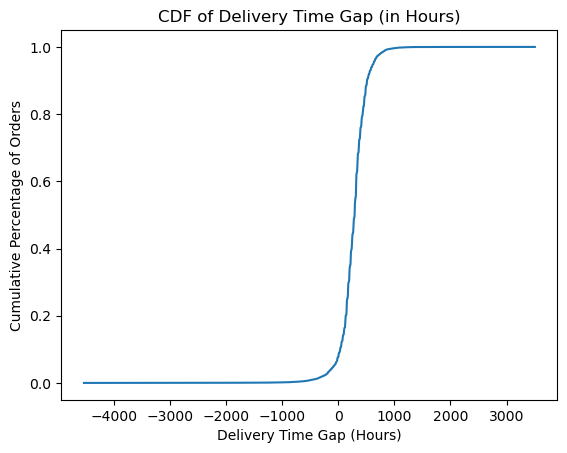

In [489]:
sorted_diff = np.sort(difference_hours)
# cumulative distribution function
cdf = np.arange(len(sorted_diff)) / len(sorted_diff)

plt.plot(sorted_diff, cdf)
plt.title("CDF of Delivery Time Gap (in Hours)")
plt.xlabel("Delivery Time Gap (Hours)")
plt.ylabel("Cumulative Percentage of Orders")
plt.show()

In [490]:
len(difference_hours[difference_hours.between(-1000, 1000)])

86704

In [491]:
len(difference_hours)
# 87165 - 86704 = 461, number of outlying entries, comes in use later for verifying

87165

#### Adding columns for difference between estimated & actual delivery time in datetime & in hrs.
Then, Removing the data from orders data that has difference between estimated & actual delivery date not in (-1000, 1000) hrs.
from the observation from above graphs.

In [492]:
orders['delivery_time_gap'] = (
    orders['order_estimated_delivery_date'] - orders['order_delivered_timestamp']
).where(orders['order_delivered_timestamp'].notna())
# where() function is used as delivered_timestamp has null values in canceled or shipped orders.
orders['delivery_time_gap_hrs'] = orders['delivery_time_gap'].dt.total_seconds()/3600
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_time_gap,delivery_time_gap_hrs
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,13 days 01:40:08,313.668889
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,20 days 01:08:38,481.143889
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08,8 days 22:30:10,214.502778
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19,22 days 03:56:09,531.935833
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18,12 days 04:37:11,292.619722


In [493]:
orders.shape

(89016, 9)

In [494]:
orders = orders[orders['delivery_time_gap_hrs'].between(-1000, 1000, inclusive='both') | orders['delivery_time_gap_hrs'].isna()]

#remove references from other files too
order_items = order_items[order_items['order_id'].isin(orders['order_id'])]
payments = payments[payments['order_id'].isin(orders['order_id'])]

In [495]:
orders.shape
# 89016 - 88555 = 461, equals to the previously calculated number of outlying entries.

(88555, 9)

#### Adding more columns for `purchase_to_approval_hours`, `approval_to_delivery_hours` & `purchase_to_delivery_hours`

In [496]:
orders.shape

(88555, 9)

In [497]:
orders['purchase_to_approval_hours'] = (
    orders['order_approved_at'] - orders['order_purchase_timestamp']
).dt.total_seconds()/3600

In [498]:
orders['approval_to_delivery_hours'] = (
    orders['order_delivered_timestamp'] - orders['order_approved_at']
).where(orders['order_delivered_timestamp'].notna()).dt.total_seconds()/3600
# where() function is used as delivered_timestamp has null values in canceled or shipped orders.

In [499]:
orders['purchase_to_delivery_hours'] = (
    orders['purchase_to_approval_hours'] + orders['approval_to_delivery_hours']
).where(orders['order_delivered_timestamp'].notna())

In [500]:
orders.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_time_gap,delivery_time_gap_hrs,purchase_to_approval_hours,approval_to_delivery_hours,purchase_to_delivery_hours
71476,6tr01tgD0gIb,Tnr3NjiLNYnc,delivered,2018-05-12 13:41:48,2018-05-15 04:35:11,2018-05-23 14:36:44,2018-06-06,13 days 09:23:16,321.387778,62.889722,202.025833,264.915556


In [501]:
orders.shape

(88555, 12)

#### Saving the cleaned file in `processed` data folder

In [502]:
orders.to_csv('../data/processed/orders_cleaned.csv', index=False)

---

### Order Items Data (df_OrderItems.csv)

**🧼 Data Cleaning Summary — Order Items File**
- Changed data types for all timestamp columns.
- Removed 2016 data (insignificant and noisy).
- Removed rows where order_status = 'canceled' but had non-null delivery timestamp.
- Dropped delivered rows with missing delivery timestamp.
- Calculated delivery_time_gap_hrs and removed extreme outliers using KDE and CDF plots.
- Added new features: delivery_time_gap, delivery_time_gap_hrs, purchase_to_approval_hours, approval_to_delivery_hours.

In [503]:
order_items['order_id'] = order_items['order_id'].astype('string')
order_items['product_id'] = order_items['product_id'].astype('string')
order_items['seller_id'] = order_items['seller_id'].astype('string')

In [504]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88555 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          88555 non-null  string 
 1   product_id        88555 non-null  string 
 2   seller_id         88555 non-null  string 
 3   price             88555 non-null  float64
 4   shipping_charges  88555 non-null  float64
dtypes: float64(2), string(3)
memory usage: 4.1 MB


In [505]:
order_items.sample()

,order_id,product_id,seller_id,price,shipping_charges
73209,kpoVATA7kfEp,KIYt8ODpiQyI,TBkUw9PKrND5,340.8,37.07


### Handling Outliers in <span style='color: gray;'>*price*</span> Values

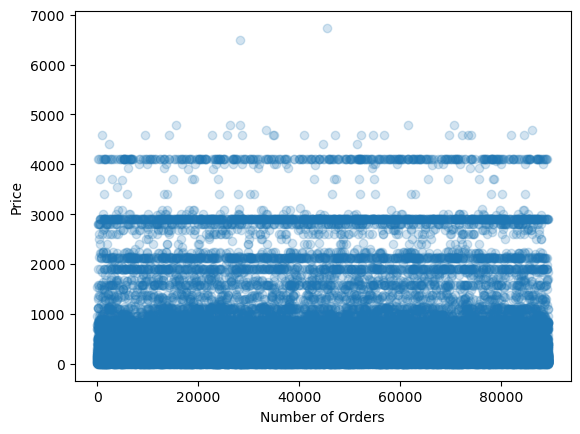

In [507]:
plt.scatter(order_items['price'].index, order_items['price'], alpha=0.2)
plt.ylabel("Price")
plt.xlabel("Number of Orders")
plt.show()

In [508]:
order_items[order_items['price'] > 3500]['price'].value_counts()
# this justifies the crowded line over 4000 & similarly other crowded lined as well.

price
4099.99    391
3999.90     23
4590.00     19
3699.99     16
3930.00      7
4799.00      5
4399.87      3
3899.00      2
4690.00      2
3980.00      2
3549.00      1
3690.00      1
6499.00      1
6735.00      1
3999.00      1
4059.00      1
Name: count, dtype: int64

---
#### Two outliers spotted lets check if they can be removed or are just natural

In [509]:
order_items[order_items['price'] > 5000]

,order_id,product_id,seller_id,price,shipping_charges
28299,aPnggTzFcusk,7tZV2OpLVZHg,nt1w9AssyxfU,6499.0,70.06
45436,SwjsVBeUO9OM,HiyKPuVcad18,4SWsneYKnFcc,6735.0,3.82


Checking the seller selling the outlying products **:**

First seller sells almost *all items for less than 2000*, and one item for highest price is likely in an **outlier**.
<br>Same for the second one, but that product has two orders with *one price being 30.3 & while the other is 6735*, its obviously an **outlier**.

In [510]:
order_items[(order_items['seller_id']=='nt1w9AssyxfU') & (order_items['price'] > 2000)]

,order_id,product_id,seller_id,price,shipping_charges
28299,aPnggTzFcusk,7tZV2OpLVZHg,nt1w9AssyxfU,6499.0,70.06
67280,3g7emgFVrEmt,YUHPB48nCMIU,nt1w9AssyxfU,2221.0,4.85


In [511]:
order_items[(order_items['seller_id']=='4SWsneYKnFcc') & (order_items['price'] > 1000)]

,order_id,product_id,seller_id,price,shipping_charges
45436,SwjsVBeUO9OM,HiyKPuVcad18,4SWsneYKnFcc,6735.0,3.82


In [512]:
order_items[(order_items['product_id']=='HiyKPuVcad18')]

,order_id,product_id,seller_id,price,shipping_charges
42647,RqHAb6zx28mO,HiyKPuVcad18,4SWsneYKnFcc,30.3,7.19
45436,SwjsVBeUO9OM,HiyKPuVcad18,4SWsneYKnFcc,6735.0,3.82


**Removing the `Price` Outliers**

In [513]:
order_items = order_items[~(order_items['price'] > 6000)]

#remove references from other files too
orders = orders[orders['order_id'].isin(order_items['order_id'])]
payments = payments[payments['order_id'].isin(order_items['order_id'])]

In [514]:
orders.shape

(88553, 12)

### Handling Outliers in <span style='color: gray;'>*shipping_charges*</span> Values

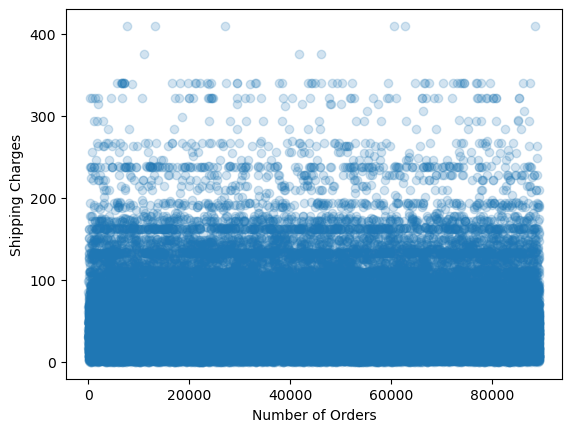

In [515]:
plt.scatter(order_items['shipping_charges'].index, order_items['shipping_charges'], alpha=0.2)
plt.ylabel("Shipping Charges")
plt.xlabel("Number of Orders")
plt.show()

In [516]:
# looking for higher values in shipping_charges having outlying nature
order_items[order_items['shipping_charges'] > 380]

,order_id,product_id,seller_id,price,shipping_charges
7660,5zanSVBXs4VQ,Y0TFdzbMEGBQ,ifxCRnLMwwNK,280.00,409.68
13208,0GQVdAatZtAz,3nFamKuMJOoh,9fFFM6RBxCkT,19.04,409.68
27141,x4USDX1BHUtF,27O0he9UZll1,wAgnN3eGF2Af,107.63,409.68
60466,JMQKyT3azSs8,iFYDVo0NCTQu,9fFFM6RBxCkT,19.04,409.68
62699,nVccq3PAbw5D,mvCVjpSlN3OU,q1Q2n7nr6h9B,2221.00,409.68
88435,ihgoQUhKSH34,3nFamKuMJOoh,9fFFM6RBxCkT,19.04,409.68


#### Adding new column/feature **`shippping_price_ratio`**

In [517]:
order_items['shipping_price_ratio'] = order_items['shipping_charges'] / order_items['price']

In [518]:
order_items[order_items['shipping_price_ratio'] > 5]

,order_id,product_id,seller_id,price,shipping_charges,shipping_price_ratio
21,MhDudBaAab78,aYw1jx6U0ZzQ,VnAPb1lEZYQ6,3.49,30.66,8.785100
48,UaZKqhLFwRZP,AQRgJU930yvK,TAkMUTMwlNUw,26.86,140.40,5.227103
77,jJgDALmwe6f6,tfJojxEnA32p,ZsDn106jXrgr,8.80,70.17,7.973864
239,07amSeyheu9N,oUaq0Emczjrp,AHG0TE6bRNNY,5.99,78.84,13.161937
282,lUA0GIMIbFvS,1gi8qMFFJtiv,LLty41IbV7xo,8.43,54.17,6.425860
...,...,...,...,...,...,...
89162,XP6qr6fpJmNd,U00xFmKF5dOF,BfK8XAwCdM0A,0.85,7.54,8.870588
89180,gPhowNjKw6FY,jfq2xYDYdD5Z,smK689qrlIx3,3.50,58.65,16.757143
89188,KyX9595aTtWd,YABPZkBP1ceo,bgTagPNdPdef,10.49,70.89,6.757865
89212,AxqlUFozhKgY,QicUIkxKgoQv,IfkTaAAVww4a,3.00,105.62,35.206667


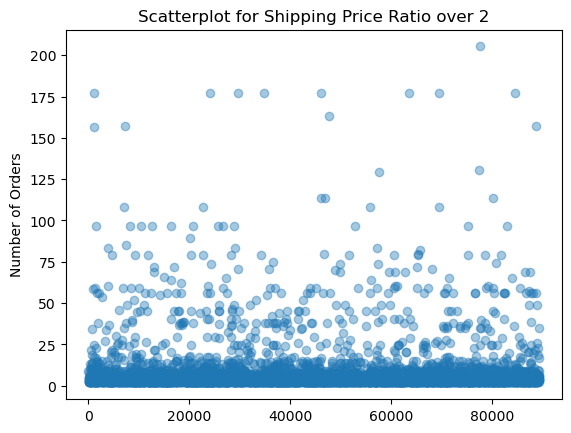

In [519]:
ratio = order_items['shipping_charges']/order_items['price']
plt.scatter(ratio[ratio > 2].index, ratio[ratio > 2], alpha=0.4)
plt.ylabel("Shipping Price Ratio")
plt.ylabel("Number of Orders")
plt.title("Scatterplot for Shipping Price Ratio over 2")
plt.show()

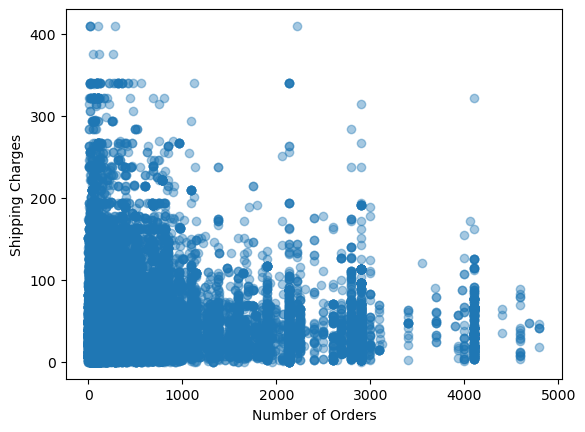

In [520]:
plt.scatter(order_items['price'], order_items['shipping_charges'], alpha=0.4)
plt.ylabel("Shipping Charges")
plt.xlabel("Number of Orders")
plt.show()

---
### Removing the entries with ratio shipping price ratio over 5

In [521]:
order_items = order_items[order_items['shipping_price_ratio'] <= 5] 

#remove references from other files too
orders = orders[orders['order_id'].isin(order_items['order_id'])]
payments = payments[payments['order_id'].isin(order_items['order_id'])]

In [522]:
order_items.shape

(86722, 6)

In [523]:
order_items[order_items['shipping_charges'].between(200, 500)]['price'].describe()

count     508.000000
mean      360.041890
std       497.169335
min        45.530000
25%        77.070000
50%       135.000000
75%       454.000000
max      4099.990000
Name: price, dtype: float64

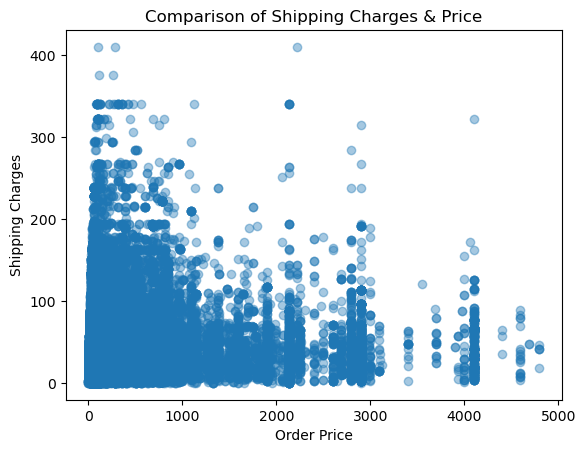

In [524]:
plt.scatter(order_items['price'], order_items['shipping_charges'], alpha=0.4)
plt.ylabel("Shipping Charges")
plt.xlabel("Order Price")
plt.title("Comparison of Shipping Charges & Price")
plt.show()

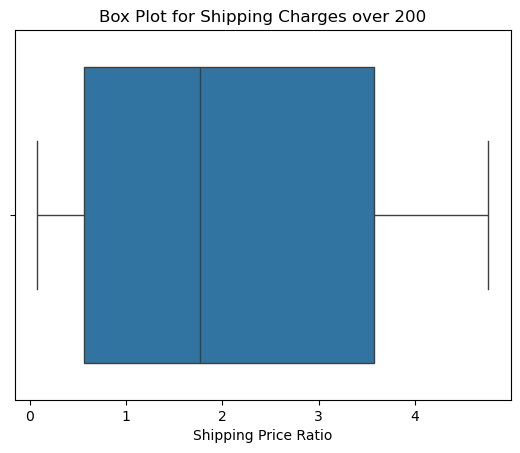

In [525]:
sns.boxplot(x=order_items[order_items['shipping_charges'] > 200]['shipping_price_ratio'])
plt.xlabel("Shipping Price Ratio")
plt.title("Box Plot for Shipping Charges over 200")
plt.show()

#### Removing data with shipping charges over 200 & shipping price ratio 1.5
This was a quite unrealistic piece of data which has very less in number (400) compared to complete data size (86k).

In [526]:
order_items = order_items[~((order_items['shipping_charges'] > 200) & (order_items['shipping_price_ratio'] > 1.5))]

#remove references from other files too
orders = orders[orders['order_id'].isin(order_items['order_id'])]
payments = payments[payments['order_id'].isin(order_items['order_id'])]

In [527]:
order_items.shape

(86443, 6)

#### Saving the cleaned file in `processed` data folder

In [ ]:
order_items.to_csv('../data/processed/order_items_cleaned.csv', index=False)